<a href="https://colab.research.google.com/github/playanaC/Skeletonizing_Unet/blob/main/Demo_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone github

In [1]:
! git clone https://github.com/playanaC/Skeletonizing_Unet.git

Cloning into 'Skeletonizing_Unet'...
remote: Enumerating objects: 910, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 910 (delta 21), reused 3 (delta 1), pack-reused 824
Receiving objects: 100% (910/910), 70.99 MiB | 21.40 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
%cd Skeletonizing_Unet/Demo_test/

/content/Skeletonizing_Unet/Demo_test


Extract Unet model

In [3]:
! cat /content/Skeletonizing_Unet/Demo_test/umf_Unet_pth.tar.bz.* > /content/Skeletonizing_Unet/Demo_test/umf_Unet_pth.tar.bz
! tar -xvjf /content/Skeletonizing_Unet/Demo_test/umf_Unet_pth.tar.bz -C /content/Skeletonizing_Unet/Demo_test/


umf_Unet.pth


Import libraries

In [7]:
import torch
from utils import *
from umf_Unet_model import UMF
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Load gray-img, ground-true image skeletons: RGB, SKL 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


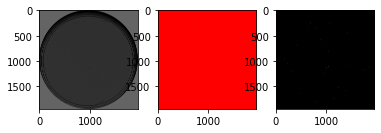

In [13]:
path_xmls = '/content/Skeletonizing_Unet/Demo_test/xml_files/'
img_path = '/content/Skeletonizing_Unet/Demo_test/RASP02_000010.cmpr'

xmls = xml_annotator(path_xmls)
img, RGB, skl_mask = img_cmpr_skl(img_path, xmls, 2, 5)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(img, cmap='gray', vmin=0, vmax=255)
ax1.imshow(RGB)
ax2.imshow(skl_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

Load model

In [5]:
best_model = '/content/Skeletonizing_Unet/Demo_test/umf_Unet.pth'

model = UMF(n_channels=1, n_classes=3, bilinear=True)
model.load_state_dict(torch.load(best_model))
model.to(device=device)

print(model)

UMF(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentu

Predict gray-img

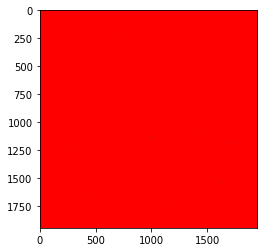

In [14]:
n_parts = 2
trans = transforms.ToPILImage()

dim = img.shape
imgP = img2parts(img, dim, n_parts)
imgP = torch.from_numpy(imgP).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0)

cnt = 0
for ji in range(n_parts):
    for ii in range(n_parts):
        predict_mask = imgP[:, :, :, :, cnt]

        predict_mask = predict_mask.to(device=device, dtype=torch.float32)
        predict_mask = model(predict_mask)
        predict_mask = torch.sigmoid(predict_mask)
        predict_mask = predict_mask.squeeze(0)
        predict_mask = trans(predict_mask.cpu())

        if ii == 0:
            predict_mask_concatH = predict_mask
        else:
            predict_mask_concatH = get_concat_v(predict_mask_concatH, predict_mask)
        cnt = cnt + 1
    if ji == 0:
        predict_mask_concatV = predict_mask_concatH
    else:
        predict_mask_concatV = get_concat_h(predict_mask_concatV, predict_mask_concatH)

rgb_predict = np.asarray(predict_mask_concatV)
plt.imshow(rgb_predict)
plt.show()

Decode RGB predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


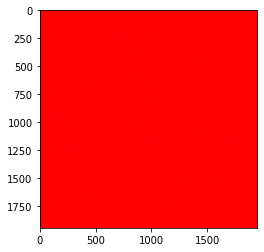

In [30]:
predict_mask = decodec_img3(predict_mask_concatV)

sz = predict_mask.shape
predict_mask_RGB = np.zeros((sz[0], sz[1], 3))
predict_mask_RGB[:, :, 0] = (predict_mask==0)*255
predict_mask_RGB[:, :, 1] = (predict_mask==1)*255
predict_mask_RGB[:, :, 2] = (predict_mask==2)*255

plt.imshow(predict_mask_RGB)
plt.show()

Select and show worms and skeletons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


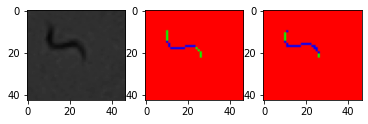

In [58]:
from skimage.measure import label, regionprops

mask_labels = label(skl_mask)
props = regionprops(mask_labels)

worm_number = 3 #select worm
nnw = 10
r0, c0, r1, c1 = props[worm_number].bbox
r0 = r0 - nnw
c0 = c0 - nnw
r1 = r1 + nnw*2
c1 = c1 + nnw*2

gray_crop = img[r0:r1, c0:c1]
skl_crop = skl_mask[r0:r1, c0:c1]

shape_arr = skl_crop.shape
rgb_crop = np.zeros((shape_arr[0], shape_arr[1], 3))
rgb_crop[:,:,0] = RGB[r0:r1, c0:c1, 0]
rgb_crop[:,:,1] = RGB[r0:r1, c0:c1, 1]
rgb_crop[:,:,2] = RGB[r0:r1, c0:c1, 2]

rgb_predict_crop = np.zeros((shape_arr[0], shape_arr[1], 3))
rgb_predict_crop[:,:,0] = predict_mask_RGB[r0:r1, c0:c1, 0]
rgb_predict_crop[:,:,1] = predict_mask_RGB[r0:r1, c0:c1, 1]
rgb_predict_crop[:,:,2] = predict_mask_RGB[r0:r1, c0:c1, 2]

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(gray_crop, cmap='gray', vmin=0, vmax=255)
ax1.imshow(rgb_crop)
ax2.imshow(rgb_predict_crop)
plt.show()